In [407]:
from itertools import izip
from time import time
import numpy as np
import astropy
from pearce.mocks.customHODModels import *
from pearce.mocks import cat_dict
from scipy.optimize import minimize

In [408]:
from SloppyJoes import lazy_wrapper

In [409]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [410]:
AB = True

In [411]:
PRIORS = {'f_c': (0, 1),
          'alpha': (0, 2),
          'logMmin':(10,16),
          'logM1': (10, 16),
          'logM0': (9,16),
          'sigma_logM': (0.1, 1.5),
          'logMcut': (9,15),
          'logMlin':(9,15),
          'f_cen': (0.0,1.0)}

_cens_model = RedMagicCens
cens_model = _cens_model(z = 0.0)
#cens_model = AssembiasReddick14Cens()
_sats_model = RedMagicSats
#sats_model = AssembiasReddick14Sats()

cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}

cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load(1.0, HOD=(_cens_model, _sats_model), hod_kwargs = {'cenocc_model': cens_model})

LBOX = 400.0

#sats_model.modulate_with_cenocc = False

In [412]:
cat.model.model_dictionary

OrderedDict([('centrals_occupation',
              <pearce.mocks.customHODModels.RedMagicCens at 0x7f55d0165c50>),
             ('satellites_occupation',
              <pearce.mocks.customHODModels.RedMagicSats at 0x7f55d0165710>),
             ('centrals_profile',
              <halotools.empirical_models.phase_space_models.analytic_models.centrals.trivial_phase_space.TrivialPhaseSpace at 0x7f55d0165910>),
             ('satellites_profile',
              <halotools.empirical_models.phase_space_models.analytic_models.satellites.nfw.nfw_phase_space.NFWPhaseSpace at 0x7f55d01654d0>)])

In [413]:
cens_model = cat.model.model_dictionary['centrals_occupation']
sats_model = cat.model.model_dictionary['satellites_occupation']

In [414]:
def liklihood(theta,params,cens_occ, sats_occ,mbc):
      
    cens_model.param_dict['f_c'] = 1.0
    sats_model.param_dict['f_c'] = 1.0
    cat.model.param_dict['f_c'] = 1.0
    cens_model.param_dict.update({p:x for p, x in izip(params, theta)})
    sats_model.param_dict.update({p:x for p, x in izip(params, theta)})
    cat.model.param_dict.update({p:x for p, x in izip(params, theta)})

    cens_preds = cens_model.mean_occupation(prim_haloprop = mbc)
    sats_preds = sats_model.mean_occupation(prim_haloprop = mbc)

    #Weird edge cases can occur?
    #cens_preds[cens_preds < 1e-9] = 0
    #sats_preds[sats_preds < 1e-9] = 0
    
    mf = cat.calc_mf(mass_bin_range = (11, 15.5), mass_bin_size=0.1)
    
    
    cens_vars = cens_preds*(1-cens_preds)*mf
    cens_vars[cens_vars < 1e-6] = 1e-6
    sats_vars = sats_preds*mf
    sats_vars[sats_vars< 1e-6] = 1e-6

    Ngal_pred = np.sum((cens_preds+sats_preds)*mf)
    Ngal_obs = np.sum((cens_occ+sats_occ)*mf)
    
    #print cens_preds
    #print cens_occ
    
    #print ((cens_preds-cens_occ)**2)/cens_vars
    
    chi2 = np.sum(((np.log10(cens_preds)-np.log10(cens_occ))**2)/np.log10(cens_vars))
    chi2+= np.sum(((np.log10(sats_preds)-np.log10(sats_occ))**2)/np.log10(sats_vars))
    chi2+= ((Ngal_pred-Ngal_obs)**2)/Ngal_obs
         
    return chi2

In [415]:
catalog = astropy.table.Table.read('/u/ki/swmclau2/des/AB_tests/abmatched_halos.hdf5', format = 'hdf5')

In [416]:
mag_cut = -21
min_ptcl = 200
if AB:
    catalog = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog['halo_vpeak_mag'] <=mag_cut)]
else:
    catalog = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog['halo_vvir_mag'] <=mag_cut)]

In [417]:
if not AB:
    pass
else:
    MAP = np.array([ 12.87956269,  12.24461447,   0.5345765,   13.98105124,   1.04527197])
       
['$\\log{M_{min}}$', '$\\log{M_0}$', '$\\sigma_{log{M}}$', '$\\log{M_1}$', '$\\alpha$']

names = ['logMmin', 'logM0', 'sigma_logM',  'logM1', 'alpha']
hod_params = dict(zip(names, MAP))

In [418]:
ab_params = {'mean_occupation_centrals_assembias_param1':0.4, 'mean_occupation_satellites_assembias_slope1':3,\
             'mean_occupation_satellites_assembias_param1':-0.5, 'mean_occupation_centrals_assembias_slope1':3,}

In [419]:
sats_model.param_dict.update(cens_model.param_dict)

In [420]:
param_dict = hod_params
#param_dict.update(ab_params)
cens_model.param_dict.update(param_dict)
sats_model.param_dict.update(param_dict)

params = sats_model.param_dict.keys()
########################
params.remove('f_c')
#######################3
ndim = len(params)

In [421]:
halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

In [422]:
detected_central_ids = set(catalog[catalog['halo_upid']==-1]['halo_id'])

In [423]:
from collections import Counter
def compute_occupations(halo_table):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_table['halo_upid'] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(catalog[catalog['halo_upid']==-1]['halo_id'])
    detected_satellite_upids = Counter(catalog[catalog['halo_upid']!=-1]['halo_upid'])

    for idx, row  in enumerate(halo_table[halo_table['halo_upid'] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [424]:
from halotools.utils.table_utils import compute_prim_haloprop_bins
def compute_hod(masses, centrals, satellites, mass_bins):
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = masses)
    mass_bin_nos = set(mass_bin_idxs)

    cens_occ = np.zeros((mass_bins.shape[0]-1,))
    sats_occ = np.zeros_like(cens_occ)
    for mb in mass_bin_nos:
        indices_of_mb = np.where(mass_bin_idxs == mb)[0]
        denom = len(indices_of_mb)
        #TODO what to do about bout 0 mean std's?
        cens_occ[mb-1] = np.mean(centrals[indices_of_mb])
        sats_occ[mb-1] = np.mean(satellites[indices_of_mb])
    return cens_occ, sats_occ

In [425]:
mass_bin_range = (11,15.5)
mass_bin_size = 0.1
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )
mbc = (mass_bins[1:]+mass_bins[:-1])/2

In [426]:
cens_occ, sats_occ = compute_occupations(halo_table )
mock_masses = halo_table[halo_table['halo_upid']==-1]['halo_mvir']
#mock_concentrations = halo_table[halo_table['halo_upid']==-1]['halo_nfw_conc']

In [427]:
cen_hod, sat_hod = compute_hod(mock_masses, cens_occ, sats_occ, mass_bins)

In [428]:
param_dict.keys()

['logM0', 'sigma_logM', 'logMmin', 'alpha', 'logM1']

In [429]:
params

['logMmin', 'logM0', 'logM1', 'sigma_logM', 'alpha']

In [430]:
vals = np.array([param_dict[key] for key in params])
cens_idxs = halo_table['halo_upid'] == -1
args = (params, cen_hod, sat_hod,mbc)
print params

['logMmin', 'logM0', 'logM1', 'sigma_logM', 'alpha']


In [431]:
test = cens_model.mean_occupation(prim_haloprop = cat.halocat.halo_table['halo_mvir'][:100],\
                           sec_haloprop= cat.halocat.halo_table['halo_nfw_conc'][:100])
print np.mean(test)

0.15759


In [432]:
import scipy.optimize as op

In [457]:
print vals
vals2=vals*(np.ones_like(vals)+0.01*(np.random.randn()-0.5))
print vals2

[ 12.87956269  12.24461447  13.98105124   0.5345765    1.04527197]
[ 12.87364502  12.23898854  13.97462748   0.53433088   1.04479171]


In [458]:
results = op.minimize(liklihood, vals2, args, method = 'L-BFGS-B', bounds = [PRIORS[p] for p in params])

In [459]:
results.success

False

In [460]:
params

['logMmin', 'logM0', 'logM1', 'sigma_logM', 'alpha']

In [461]:
results.x

array([ 12.87364502,  12.23898854,  13.97462748,   0.53433088,   1.04479171])

In [462]:
vals

array([ 12.87956269,  12.24461447,  13.98105124,   0.5345765 ,   1.04527197])

In [463]:
theta = results.x

In [464]:
cens_model.param_dict.update({p:x for p, x in izip(params, theta)})
sats_model.param_dict.update({p:x for p, x in izip(params, theta)})
cat.model.param_dict.update({p:x for p, x in izip(params, theta)})

cens_preds = cens_model.mean_occupation(prim_haloprop = mbc)
sats_preds = sats_model.mean_occupation(prim_haloprop = mbc)

In [465]:
cens_model.param_dict.update({p:x for p, x in izip(params, vals)})
sats_model.param_dict.update({p:x for p, x in izip(params, vals)})
cat.model.param_dict.update({p:x for p, x in izip(params, vals)})

mcmc_cens_preds = cens_model.mean_occupation(prim_haloprop = mbc)
mcmc_sats_preds = sats_model.mean_occupation(prim_haloprop = mbc)

(1e-06, 100.0)

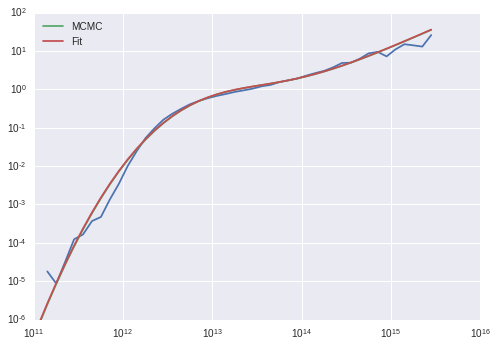

In [466]:
plt.plot(mbc, cen_hod+sat_hod)
plt.plot(mbc, mcmc_cens_preds+mcmc_sats_preds, label = 'MCMC')
plt.plot(mbc, cens_preds+sats_preds, label = 'Fit')
plt.loglog()
plt.legend(loc='best')
plt.ylim([1e-6, 1e2])

(1e-06, 10.0)

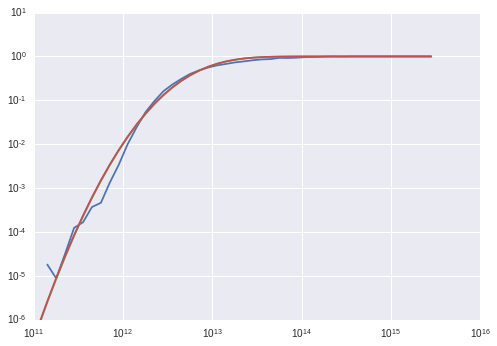

In [467]:
plt.plot(mbc, cen_hod)
plt.plot(mbc, mcmc_cens_preds)
plt.plot(mbc, cens_preds)
plt.loglog()
plt.ylim([1e-6, 1e1])

(1e-06, 100.0)

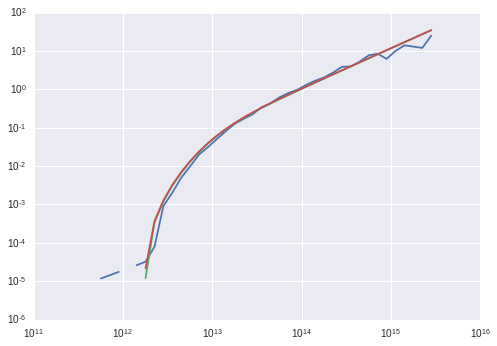

In [468]:
plt.plot(mbc, sat_hod)
plt.plot(mbc, mcmc_sats_preds)
plt.plot(mbc, sats_preds)
plt.loglog()
plt.ylim([1e-6, 1e2])